In [2]:
import math
import random
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from Bio import SeqIO
import matplotlib.pyplot as plt  # For plotting

device = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

###################################
# 1. FASTA Parsing and Filtering (same as before)
###################################
def parse_fasta_with_labels(fasta_file):
    data = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        header = record.description.strip()
        sequence = str(record.seq).upper()
        label = header.split()[0]
        data.append((label, sequence))
    return data

def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, seq in raw_data:
        label_to_samples[label].append(seq)
    
    train_data = []
    test_data = []
    for label, seqs in label_to_samples.items():
        random.shuffle(seqs)
        test_seq = seqs[0]
        train_seqs = seqs[1:]
        test_data.append((label, test_seq))
        for s in train_seqs:
            train_data.append((label, s))
    return train_data, test_data

def generate_kmers(sequence, k=6):
    kmers = []
    for i in range(len(sequence) - k + 1):
        kmers.append(sequence[i:i + k])
    return kmers

def build_kmer_vocab(dataset, k=6):
    kmer_set = set()
    for _, seq in dataset:
        kmers = generate_kmers(seq, k)
        kmer_set.update(kmers)
    vocab = {"<UNK>": 0}
    for i, kmer in enumerate(sorted(kmer_set), start=1):
        vocab[kmer] = i
    return vocab

def encode_sequence(sequence, vocab, k=6):
    kmers = generate_kmers(sequence, k)
    encoded = [vocab.get(kmer, vocab["<UNK>"]) for kmer in kmers]
    return encoded

def filter_classes(raw_data, min_count=5):
    label_counts = Counter([label for (label, _) in raw_data])
    filtered_data = [(label, seq) for (label, seq) in raw_data if label_counts[label] >= min_count]
    return filtered_data

def reverse_complement(seq):
    # For simplicity, we just reverse the sequence.
    return seq[::-1]

def create_paired_data(data_list):
    paired = []
    for label, seq in data_list:
        rev_seq = reverse_complement(seq)
        paired.append((label, seq, rev_seq))
    return paired

class TwoFastaKmerDataset(Dataset):
    """
    Each item: (encoded_seq_fwd, encoded_seq_rev, label_idx)
    """
    def __init__(self, paired_data, vocab, k=6):
        super().__init__()
        self.vocab = vocab
        self.k = k
        labels = sorted(set(item[0] for item in paired_data))
        self.label2idx = {lbl: i for i, lbl in enumerate(labels)}
        self.encoded_data = []
        for label, fwd_seq, rev_seq in paired_data:
            x1 = encode_sequence(fwd_seq, self.vocab, k=self.k)
            x2 = encode_sequence(rev_seq, self.vocab, k=self.k)
            y = self.label2idx[label]
            self.encoded_data.append((x1, x2, y))
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx]
    
    def get_vocab_size(self):
        return len(self.vocab)
    
    def get_num_classes(self):
        return len(self.label2idx)

def collate_fn_two(batch):
    seqs_fwd, seqs_rev, labels = zip(*batch)
    seq_fwd_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_fwd]
    seq_rev_tensors = [torch.tensor(s, dtype=torch.long) for s in seqs_rev]
    padded_fwd = pad_sequence(seq_fwd_tensors, batch_first=True, padding_value=0)
    padded_rev = pad_sequence(seq_rev_tensors, batch_first=True, padding_value=0)
    labels_tensors = torch.tensor(labels, dtype=torch.long)
    return padded_fwd, padded_rev, labels_tensors

###################################
# 2. ViTDeepSEAEncoder with Normalization (Branch used in each pathway)
###################################
class ViTDeepSEAEncoder(nn.Module):
    """
    This module performs:
      1. k-mer embedding.
      2. A DeepSEA-style conv block.
      3. A projection of the conv feature maps to d_model.
      4. Addition of positional embeddings.
      5. Transformer encoding (ViT style) over the resulting tokens.
      6. Pooling over tokens to produce a fixed-length vector.
    """
    def __init__(
        self,
        vocab_size,
        embed_dim=128,
        d_model=256,  # Each branch outputs a 256-D vector
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000  # maximum expected sequence length (in k-mer tokens)
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # DeepSEA-style conv block. Conv1d expects input shape [B, channels, L]
        self.deepsea_conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=num_conv_filters[0], kernel_size=conv_kernel_sizes[0]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[0]),
            nn.Conv1d(in_channels=num_conv_filters[0], out_channels=num_conv_filters[1], kernel_size=conv_kernel_sizes[1]),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=pool_kernel_sizes[1]),
            nn.Conv1d(in_channels=num_conv_filters[1], out_channels=num_conv_filters[2], kernel_size=conv_kernel_sizes[2]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        # --- Normalization Layer Added Here ---
        # BatchNorm1d is applied on the conv output with shape [B, channels, L]
        self.bn = nn.BatchNorm1d(num_conv_filters[2])
        # Project each conv output token (feature map column) to d_model
        self.proj = nn.Linear(num_conv_filters[2], d_model)
        # Define a fixed number of positional embeddings (adjust as needed)
        self.max_tokens = 150  
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.max_tokens, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
    
    def forward(self, x):
        # x: [B, seq_len] (k-mer token indices)
        x = self.embedding(x)            # [B, seq_len, embed_dim]
        x = x.transpose(1, 2)            # [B, embed_dim, seq_len] for Conv1d
        x = self.deepsea_conv(x)         # [B, num_conv_filters[-1], L_out]
        x = self.bn(x)                   # Apply batch normalization
        x = x.transpose(1, 2)            # [B, L_out, num_conv_filters[-1]]
        x = self.proj(x)                 # [B, L_out, d_model]
        B, L, _ = x.size()
        # Use positional embeddings (truncate if necessary)
        pos_embed = self.pos_embedding[:, :L, :]
        x = x + pos_embed
        x = self.transformer_encoder(x)  # [B, L, d_model]
        # Pool over tokens (mean pooling)
        x = x.mean(dim=1)                # [B, d_model]
        return x

###################################
# 3. Two-Branch Fusion Model with FC Head
###################################
class TwoViTDeepSEAFusionDNAClassifierWithFC(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        d_model=256,  # Each branch outputs 256-D features; concat gives 512-D
        num_conv_filters=(320, 480, 960),
        conv_kernel_sizes=(8, 8, 8),
        pool_kernel_sizes=(4, 4),
        num_transformer_layers=2,
        nhead=8,
        dropout=0.1,
        max_seq_len=1000
    ):
        super().__init__()
        # Two independent branches for forward and reverse sequences.
        self.vit_branch1 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        self.vit_branch2 = ViTDeepSEAEncoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            d_model=d_model,
            num_conv_filters=num_conv_filters,
            conv_kernel_sizes=conv_kernel_sizes,
            pool_kernel_sizes=pool_kernel_sizes,
            num_transformer_layers=num_transformer_layers,
            nhead=nhead,
            dropout=dropout,
            max_seq_len=max_seq_len
        )
        # Fully connected layer: 512 -> num_classes
        self.fc = nn.Linear(2 * d_model, num_classes)
    
    def forward(self, x1, x2):
        # x1: [B, seq_len1] (forward sequence)
        # x2: [B, seq_len2] (reverse sequence)
        f1 = self.vit_branch1(x1)  # [B, d_model] -> [B, 256]
        f2 = self.vit_branch2(x2)  # [B, d_model] -> [B, 256]
        fused = torch.cat([f1, f2], dim=1)  # [B, 512]
        logits = self.fc(fused)             # [B, num_classes]
        return logits

###################################
# 4. Putting It All Together
###################################
fasta_file = "data2/fungi_ITS_cleaned.fasta"

raw_data = parse_fasta_with_labels(fasta_file)
raw_data = filter_classes(raw_data, min_count=5)  # Use classes with at least 5 samples
train_data, test_data = create_train_test_split(raw_data)

paired_train = create_paired_data(train_data)
paired_test  = create_paired_data(test_data)

# Build vocabulary from both forward and reverse sequences
combined_paired = paired_train + paired_test
tmp_data = []
for (lbl, fwd, rev) in combined_paired:
    tmp_data.append((lbl, fwd))
    tmp_data.append((lbl, rev))
k = 6
vocab = build_kmer_vocab(tmp_data, k=k)

train_dataset = TwoFastaKmerDataset(paired_train, vocab, k=k)
test_dataset  = TwoFastaKmerDataset(paired_test,  vocab, k=k)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_two)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_two)

num_classes = train_dataset.get_num_classes()
vocab_size = train_dataset.get_vocab_size()

print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {len(train_dataset)}")

# Create the model with the FC head.
model = TwoViTDeepSEAFusionDNAClassifierWithFC(
    vocab_size=vocab_size,
    num_classes=num_classes,
    embed_dim=128,
    d_model=256,  # Each branch outputs 256-D features => concat gives 512-D
    num_conv_filters=(320, 480, 960),
    conv_kernel_sizes=(8, 8, 8),
    pool_kernel_sizes=(4, 4),
    num_transformer_layers=2,
    nhead=8,
    dropout=0.1,
    max_seq_len=1000
).to(device)

# --- Lower Learning Rate Applied Here (point 1) ---
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

###################################
# 5. Train & Evaluate with Gradient Clipping (point 2)
###################################
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for fwd, rev, labels in data_loader:
            fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
            logits = model(fwd, rev)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

# Lists to store accuracy for plotting
train_acc_list = []
test_acc_list = []

epochs = 200
for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0
    for fwd, rev, labels in train_loader:
        fwd, rev, labels = fwd.to(device), rev.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(fwd, rev)
        loss = criterion(logits, labels)
        loss.backward()
        # --- Gradient Clipping Applied Here (point 2) ---
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_acc = evaluate_accuracy(model, train_loader)
    test_acc  = evaluate_accuracy(model, test_loader)
    
    # Append the accuracies for plotting
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Number of classes: 247
Number of training samples: 2500
Epoch 1/200 | Loss: 4.6527 | Train Acc: 14.16% | Test Acc: 2.02%
Epoch 2/200 | Loss: 3.3398 | Train Acc: 25.48% | Test Acc: 5.26%
Epoch 3/200 | Loss: 2.3385 | Train Acc: 11.44% | Test Acc: 2.83%
Epoch 4/200 | Loss: 1.5929 | Train Acc: 50.52% | Test Acc: 16.60%
Epoch 5/200 | Loss: 1.0410 | Train Acc: 23.40% | Test Acc: 6.07%
Epoch 6/200 | Loss: 0.6561 | Train Acc: 32.40% | Test Acc: 12.55%
Epoch 7/200 | Loss: 0.3724 | Train Acc: 44.24% | Test Acc: 19.84%
Epoch 8/200 | Loss: 0.2234 | Train Acc: 45.20% | Test Acc: 15.79%
Epoch 9/200 | Loss: 0.1234 | Train Acc: 54.48% | Test Acc: 14.17%
Epoch 10/200 | Loss: 0.0685 | Train Acc: 24.20% | Test Acc: 10.12%
Epoch 11/200 | Loss: 0.0394 | Train Acc: 74.60% | Test Acc: 24.70%
Epoch 12/200 | Loss: 0.0193 | Train Acc: 58.96% | Test Acc: 21.05%
Epoch 13/200 | Loss: 0.0108 | Train Acc: 99.12% | Test Acc: 41.30%
Epoch 14/200 | Loss: 0.0056 | Train Acc: 99.80% | Test Acc: 57.89%
Epoch 15/200 | Loss

Highest Test Accuracy: 77.73% at Epoch 192


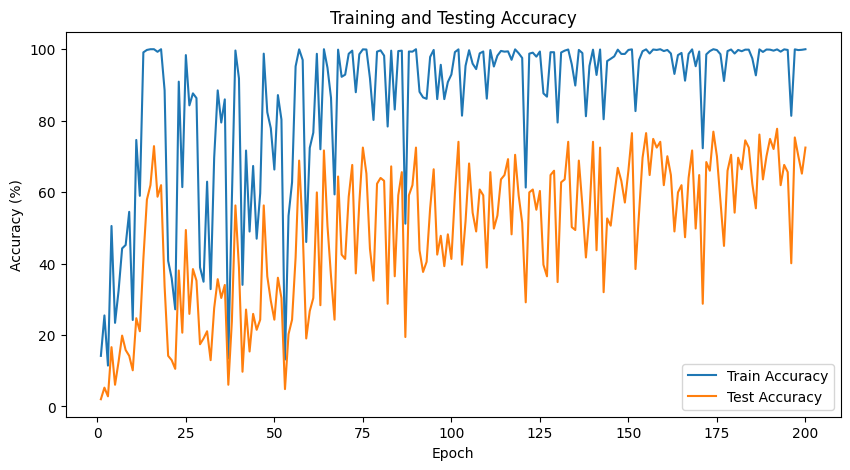

In [3]:
###################################
# 6. Print the highest test accuracy and its corresponding epoch
###################################
best_test_acc = max(test_acc_list)
best_epoch = test_acc_list.index(best_test_acc) + 1  # epochs are 1-indexed
print(f"Highest Test Accuracy: {best_test_acc:.2f}% at Epoch {best_epoch}")

###################################
# 7. Plotting the Training and Testing Accuracy
###################################
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_acc_list, label="Train Accuracy")
plt.plot(epochs_range, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy")
plt.legend()
plt.show()